In [1]:
from evaluation_loader import EvaluationLoader 
import os

In [2]:
MODEL_NAMES = [
    'base_model',
    'full_fine_tuning_set_small',
    'full_fine_tuning_set_medium',
    'full_fine_tuning_set_full',
    'head_fine_tuning_set_small',
    'head_fine_tuning_set_medium',
    'head_fine_tuning_set_full',
    'adapters_inner_dim_48_set_small',
    'adapters_inner_dim_48_set_medium',
    'adapters_inner_dim_48_set_full',
    'adapters_inner_dim_96_set_small',
    'adapters_inner_dim_96_set_medium',
    'adapters_inner_dim_96_set_full',
    'lora_r_32_alpha_64_set_small',
    'lora_r_32_alpha_64_set_medium',
    'lora_r_32_alpha_64_set_full',
    'lora_r_64_alpha_32_set_small',
    'lora_r_64_alpha_32_set_medium',
    'lora_r_64_alpha_32_set_full'
]

EVALUATION_PATH = './evaluation_metrics'

In [3]:
loader = EvaluationLoader()

In [4]:
for model_name in MODEL_NAMES:
    loader.load_results(os.path.join(EVALUATION_PATH, model_name + '.json'))
    print('Base metrics for model: ', model_name)
    loader.get_base_metrics()

Loaded evaluation results from ./evaluation_metrics/base_model.json
Confusion matrix for model:  base_model
accuracy      - 0.49564
precision     - 0.4848789119919384
f1_score      - 0.38648661970086884
roc_auc_score - 0.5027570784
Loaded evaluation results from ./evaluation_metrics/full_fine_tuning_set_small.json
Confusion matrix for model:  full_fine_tuning_set_small
accuracy      - 0.80668
precision     - 0.8080546136190757
f1_score      - 0.8064640990903813
roc_auc_score - 0.8829104864
Loaded evaluation results from ./evaluation_metrics/full_fine_tuning_set_medium.json
Confusion matrix for model:  full_fine_tuning_set_medium
accuracy      - 0.89864
precision     - 0.8991805863172142
f1_score      - 0.8986056719362907
roc_auc_score - 0.9632961856000001
Loaded evaluation results from ./evaluation_metrics/full_fine_tuning_set_full.json
Confusion matrix for model:  full_fine_tuning_set_full
accuracy      - 0.93556
precision     - 0.9360452702463864
f1_score      - 0.9355420663590034
ro

Loaded evaluation results from ./evaluation_metrics/base_model.json
Confusion matrix for model:  base_model


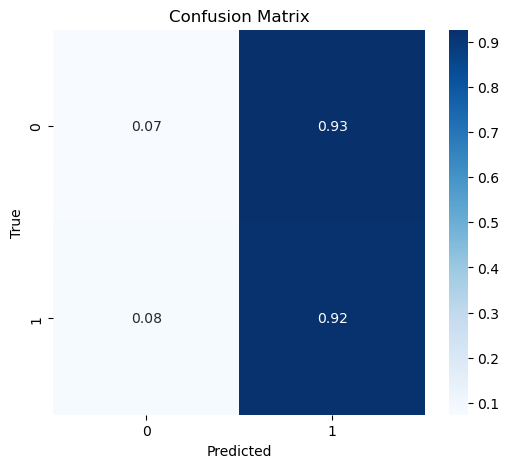

Loaded evaluation results from ./evaluation_metrics/full_fine_tuning_set_small.json
Confusion matrix for model:  full_fine_tuning_set_small


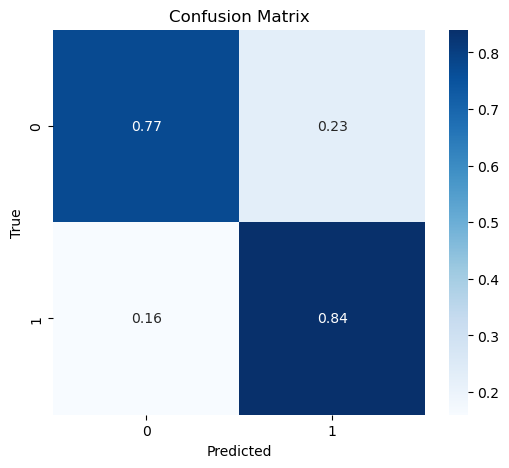

Loaded evaluation results from ./evaluation_metrics/full_fine_tuning_set_medium.json
Confusion matrix for model:  full_fine_tuning_set_medium


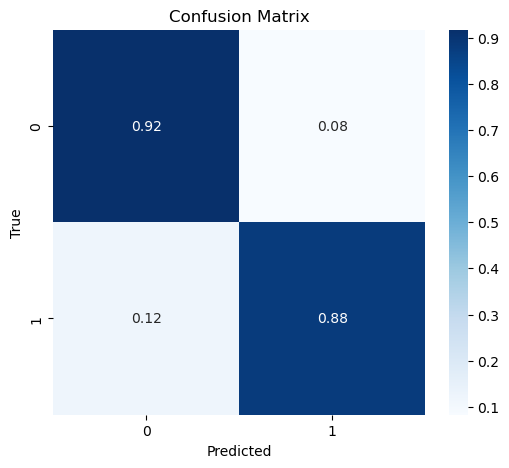

Loaded evaluation results from ./evaluation_metrics/full_fine_tuning_set_full.json
Confusion matrix for model:  full_fine_tuning_set_full


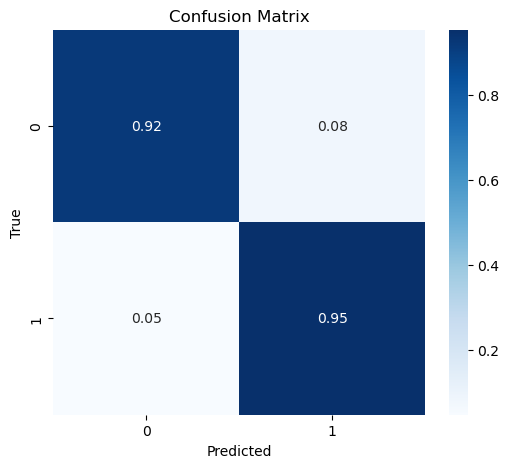

Loaded evaluation results from ./evaluation_metrics/head_fine_tuning_set_small.json
Confusion matrix for model:  head_fine_tuning_set_small


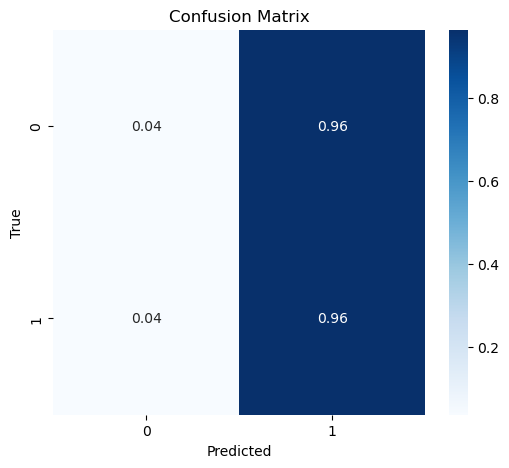

Loaded evaluation results from ./evaluation_metrics/head_fine_tuning_set_medium.json
Confusion matrix for model:  head_fine_tuning_set_medium


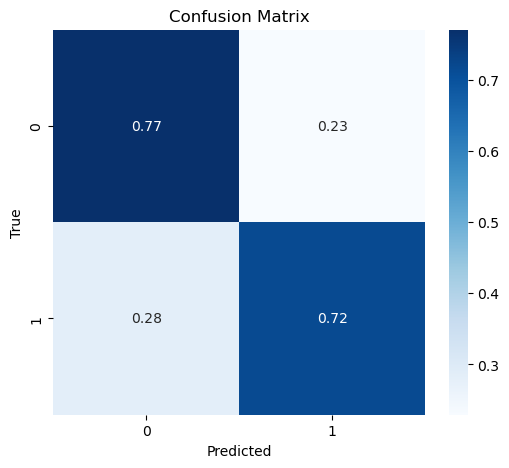

Loaded evaluation results from ./evaluation_metrics/head_fine_tuning_set_full.json
Confusion matrix for model:  head_fine_tuning_set_full


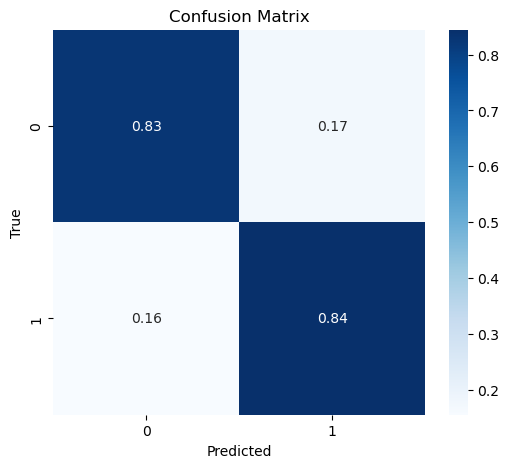

Loaded evaluation results from ./evaluation_metrics/adapters_inner_dim_48_set_small.json
Confusion matrix for model:  adapters_inner_dim_48_set_small


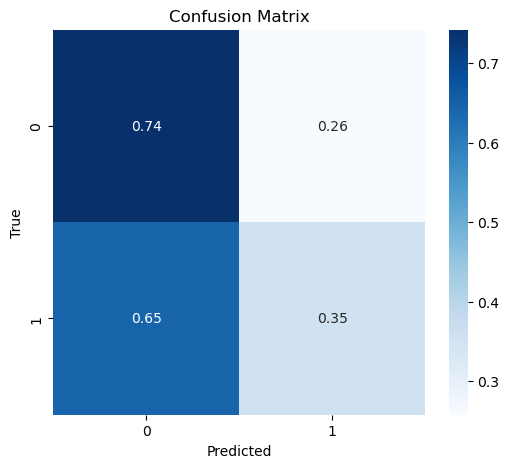

Loaded evaluation results from ./evaluation_metrics/adapters_inner_dim_48_set_medium.json
Confusion matrix for model:  adapters_inner_dim_48_set_medium


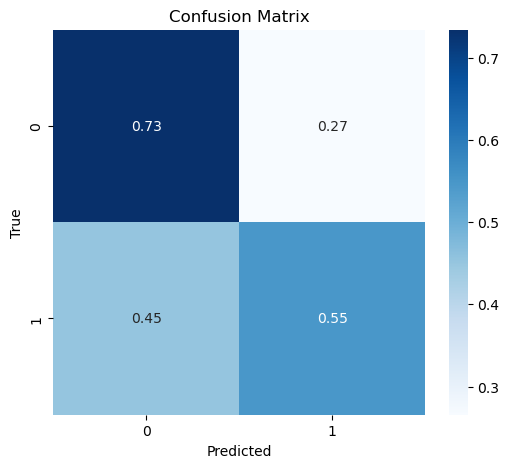

Loaded evaluation results from ./evaluation_metrics/adapters_inner_dim_48_set_full.json
Confusion matrix for model:  adapters_inner_dim_48_set_full


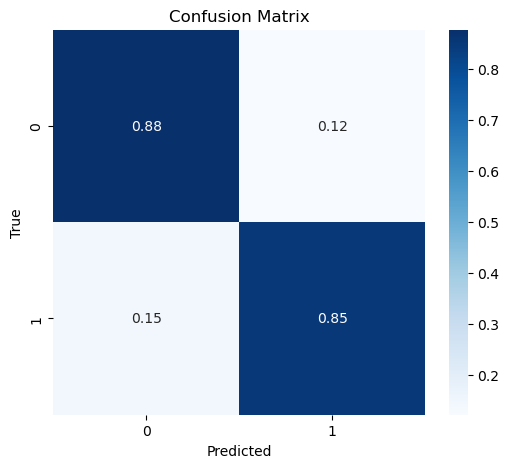

Loaded evaluation results from ./evaluation_metrics/adapters_inner_dim_96_set_small.json
Confusion matrix for model:  adapters_inner_dim_96_set_small


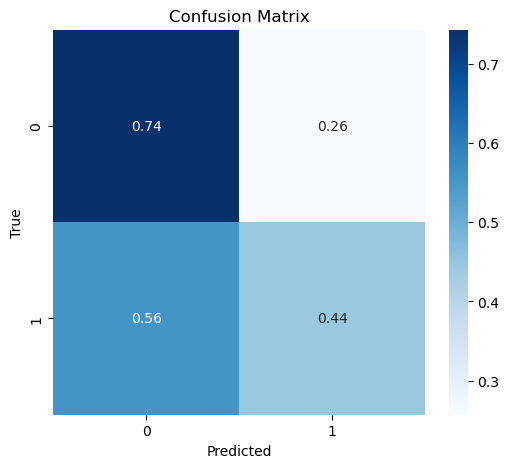

Loaded evaluation results from ./evaluation_metrics/adapters_inner_dim_96_set_medium.json
Confusion matrix for model:  adapters_inner_dim_96_set_medium


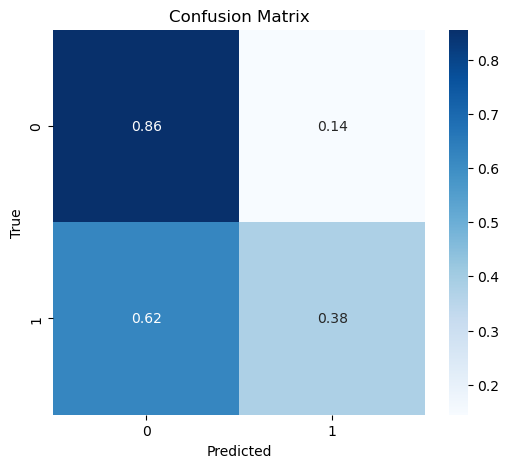

Loaded evaluation results from ./evaluation_metrics/adapters_inner_dim_96_set_full.json
Confusion matrix for model:  adapters_inner_dim_96_set_full


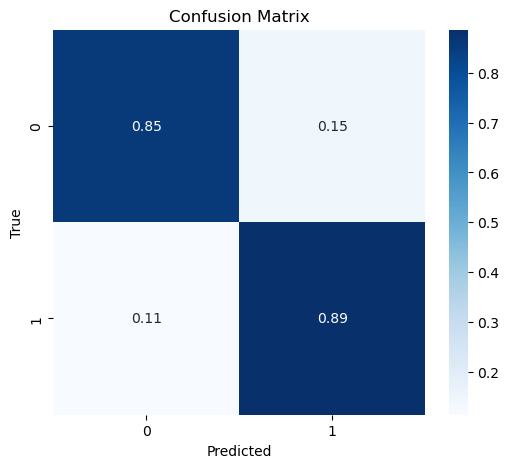

Loaded evaluation results from ./evaluation_metrics/lora_r_32_alpha_64_set_small.json
Confusion matrix for model:  lora_r_32_alpha_64_set_small


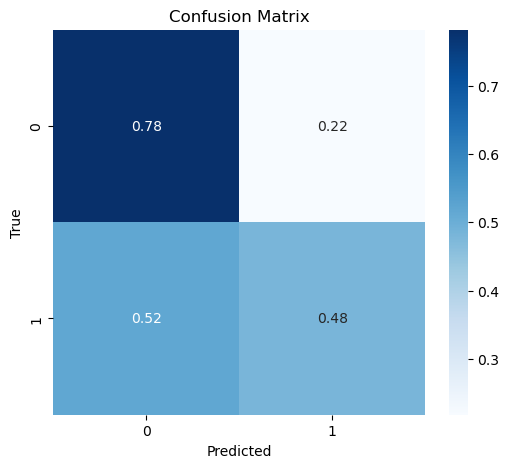

Loaded evaluation results from ./evaluation_metrics/lora_r_32_alpha_64_set_medium.json
Confusion matrix for model:  lora_r_32_alpha_64_set_medium


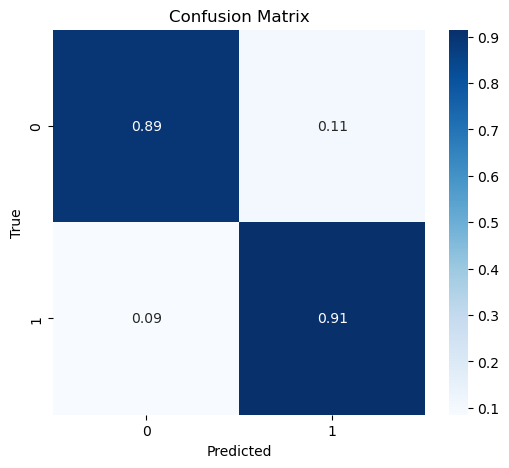

Loaded evaluation results from ./evaluation_metrics/lora_r_32_alpha_64_set_full.json
Confusion matrix for model:  lora_r_32_alpha_64_set_full


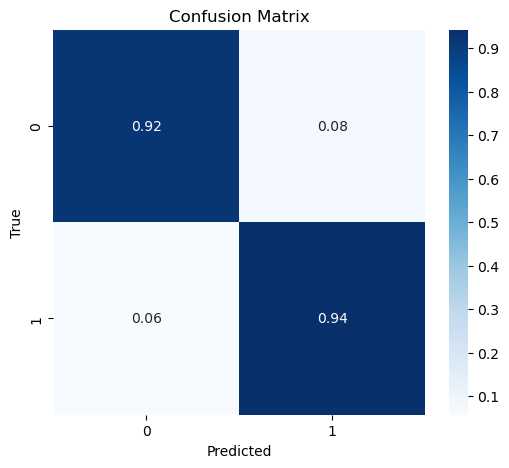

Loaded evaluation results from ./evaluation_metrics/lora_r_64_alpha_32_set_small.json
Confusion matrix for model:  lora_r_64_alpha_32_set_small


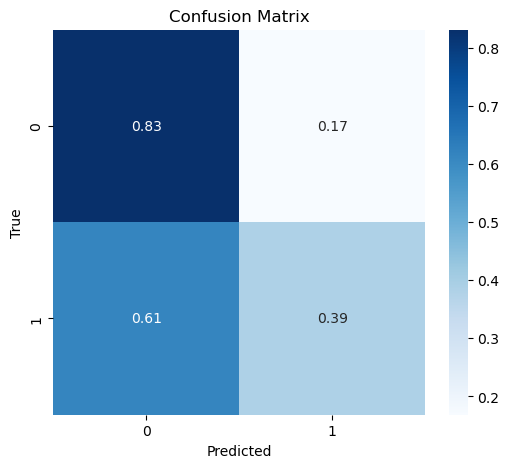

Loaded evaluation results from ./evaluation_metrics/lora_r_64_alpha_32_set_medium.json
Confusion matrix for model:  lora_r_64_alpha_32_set_medium


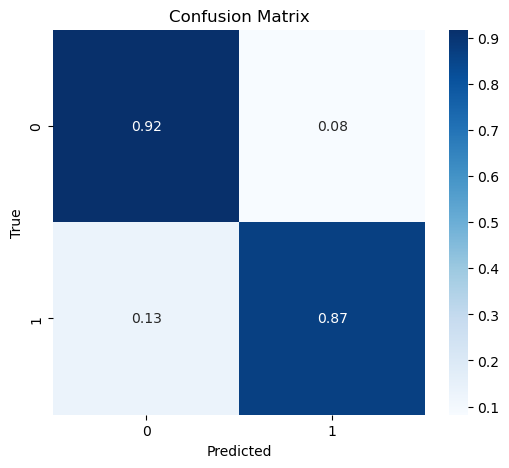

Loaded evaluation results from ./evaluation_metrics/lora_r_64_alpha_32_set_full.json
Confusion matrix for model:  lora_r_64_alpha_32_set_full


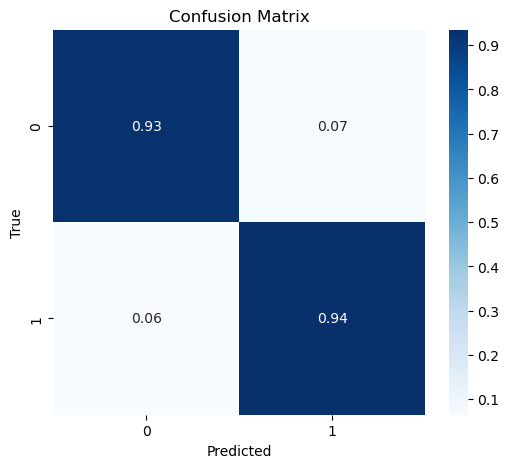

In [5]:
for model_name in MODEL_NAMES:
    loader.load_results(os.path.join(EVALUATION_PATH, model_name + '.json'))
    print('Confusion matrix for model: ', model_name)
    loader.plot_confusion_matrix()

Loaded evaluation results from ./evaluation_metrics/base_model.json
Roc curve for model:  base_model


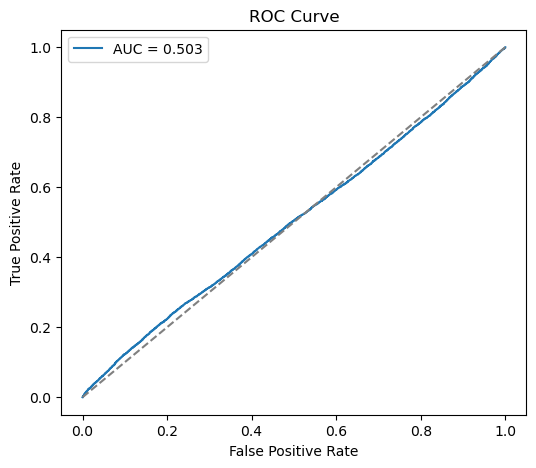

Loaded evaluation results from ./evaluation_metrics/full_fine_tuning_set_small.json
Roc curve for model:  full_fine_tuning_set_small


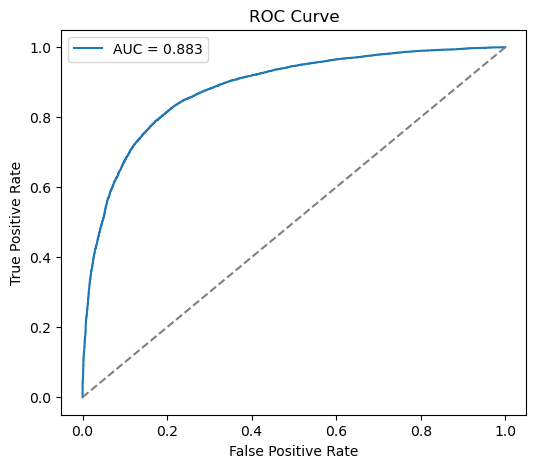

Loaded evaluation results from ./evaluation_metrics/full_fine_tuning_set_medium.json
Roc curve for model:  full_fine_tuning_set_medium


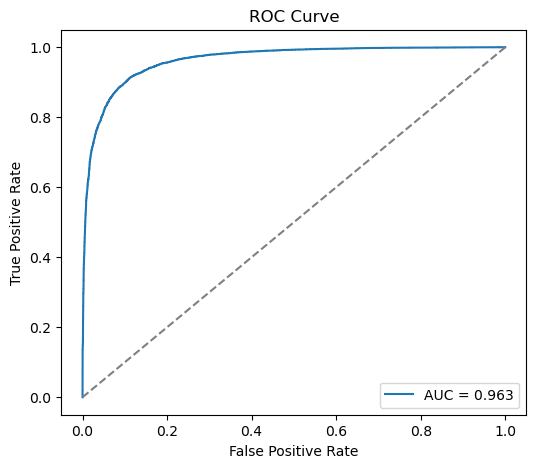

Loaded evaluation results from ./evaluation_metrics/full_fine_tuning_set_full.json
Roc curve for model:  full_fine_tuning_set_full


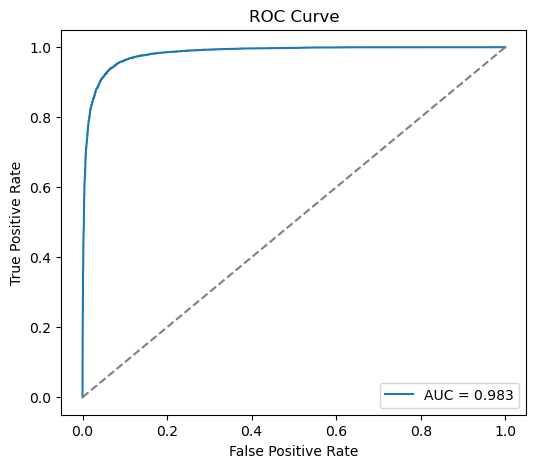

Loaded evaluation results from ./evaluation_metrics/head_fine_tuning_set_small.json
Roc curve for model:  head_fine_tuning_set_small


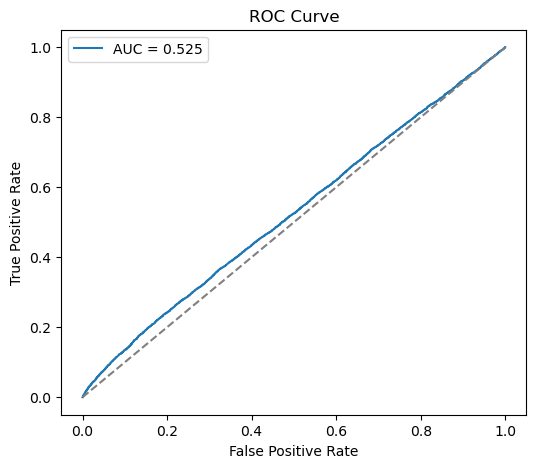

Loaded evaluation results from ./evaluation_metrics/head_fine_tuning_set_medium.json
Roc curve for model:  head_fine_tuning_set_medium


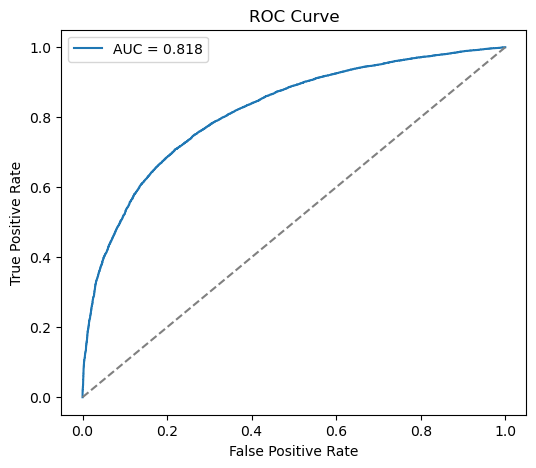

Loaded evaluation results from ./evaluation_metrics/head_fine_tuning_set_full.json
Roc curve for model:  head_fine_tuning_set_full


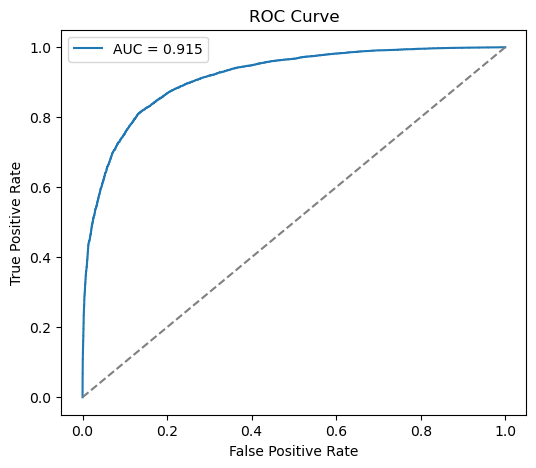

Loaded evaluation results from ./evaluation_metrics/adapters_inner_dim_48_set_small.json
Roc curve for model:  adapters_inner_dim_48_set_small


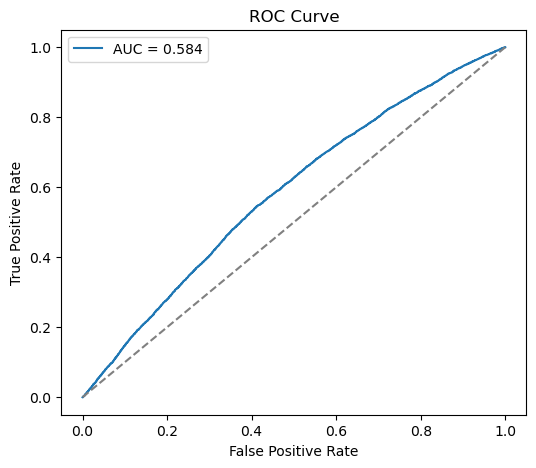

Loaded evaluation results from ./evaluation_metrics/adapters_inner_dim_48_set_medium.json
Roc curve for model:  adapters_inner_dim_48_set_medium


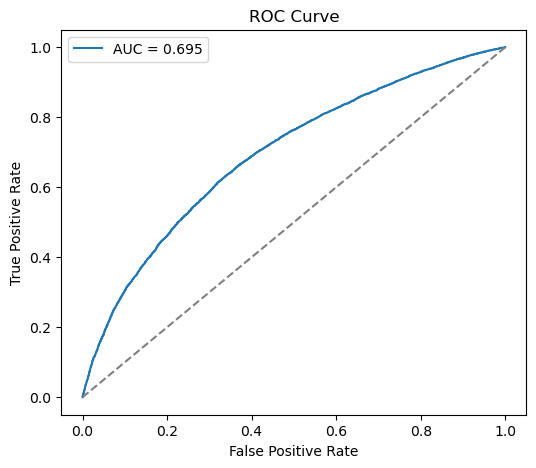

Loaded evaluation results from ./evaluation_metrics/adapters_inner_dim_48_set_full.json
Roc curve for model:  adapters_inner_dim_48_set_full


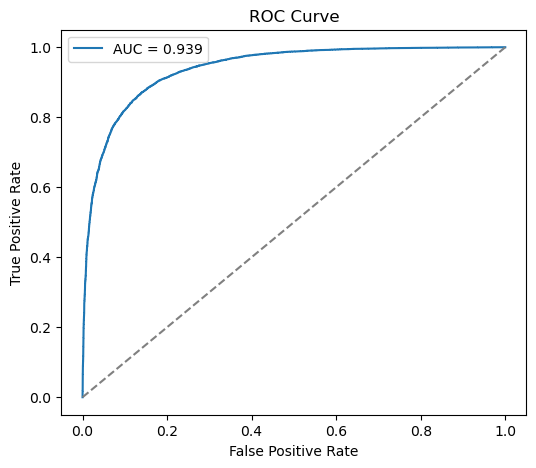

Loaded evaluation results from ./evaluation_metrics/adapters_inner_dim_96_set_small.json
Roc curve for model:  adapters_inner_dim_96_set_small


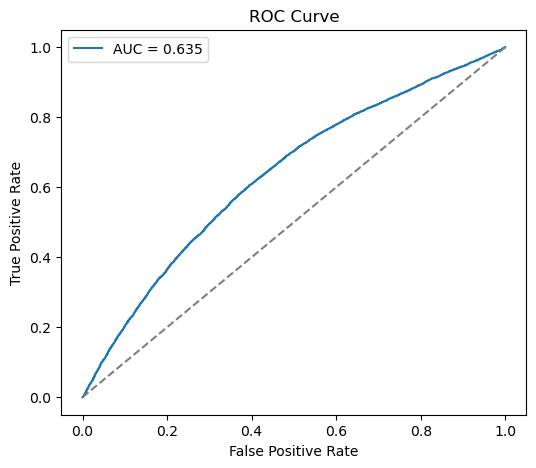

Loaded evaluation results from ./evaluation_metrics/adapters_inner_dim_96_set_medium.json
Roc curve for model:  adapters_inner_dim_96_set_medium


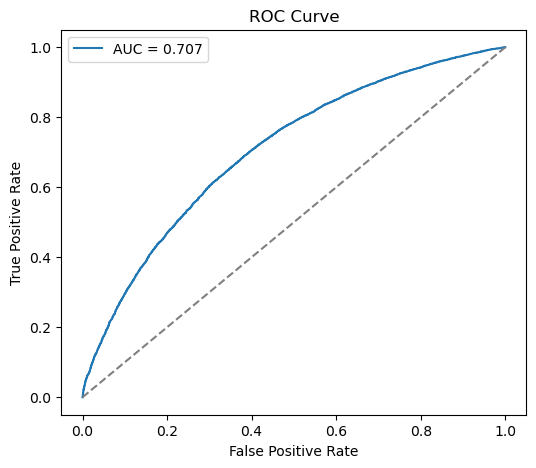

Loaded evaluation results from ./evaluation_metrics/adapters_inner_dim_96_set_full.json
Roc curve for model:  adapters_inner_dim_96_set_full


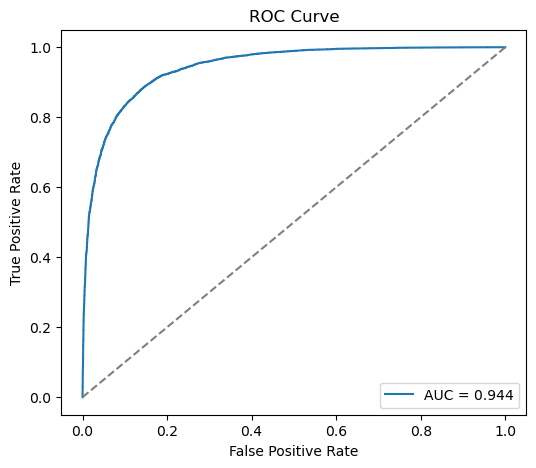

Loaded evaluation results from ./evaluation_metrics/lora_r_32_alpha_64_set_small.json
Roc curve for model:  lora_r_32_alpha_64_set_small


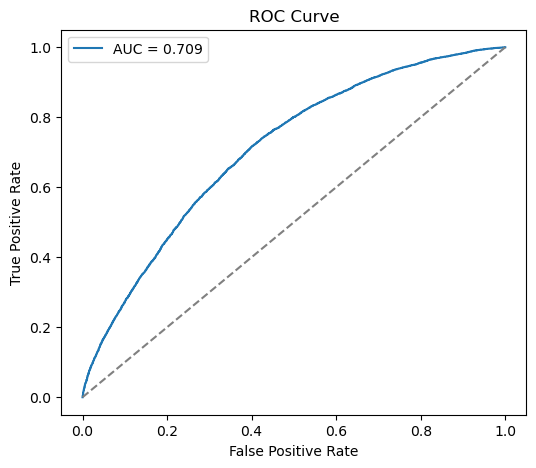

Loaded evaluation results from ./evaluation_metrics/lora_r_32_alpha_64_set_medium.json
Roc curve for model:  lora_r_32_alpha_64_set_medium


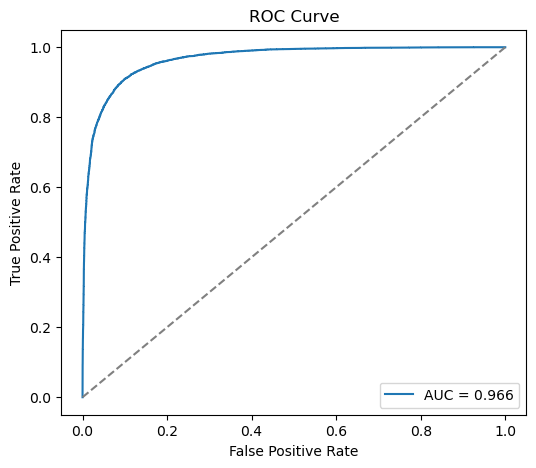

Loaded evaluation results from ./evaluation_metrics/lora_r_32_alpha_64_set_full.json
Roc curve for model:  lora_r_32_alpha_64_set_full


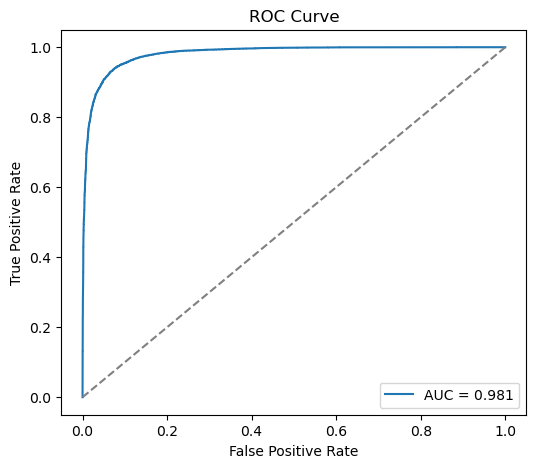

Loaded evaluation results from ./evaluation_metrics/lora_r_64_alpha_32_set_small.json
Roc curve for model:  lora_r_64_alpha_32_set_small


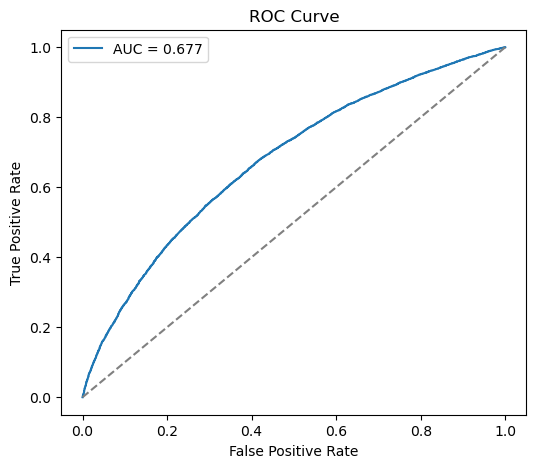

Loaded evaluation results from ./evaluation_metrics/lora_r_64_alpha_32_set_medium.json
Roc curve for model:  lora_r_64_alpha_32_set_medium


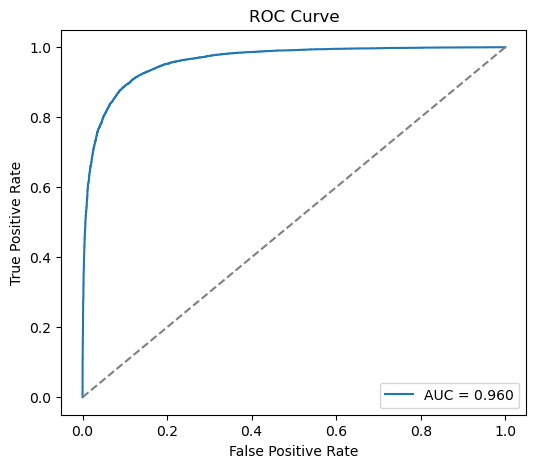

Loaded evaluation results from ./evaluation_metrics/lora_r_64_alpha_32_set_full.json
Roc curve for model:  lora_r_64_alpha_32_set_full


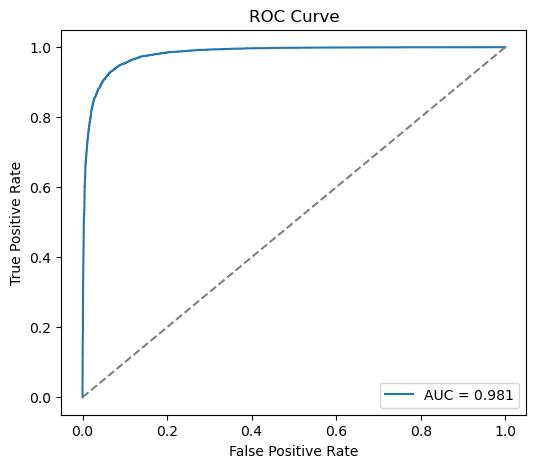

In [6]:
for model_name in MODEL_NAMES:
    loader.load_results(os.path.join(EVALUATION_PATH, model_name + '.json'))
    print('Roc curve for model: ', model_name)
    loader.plot_roc_curve()

Loaded evaluation results from ./evaluation_metrics/base_model.json
Roc curve for model:  base_model


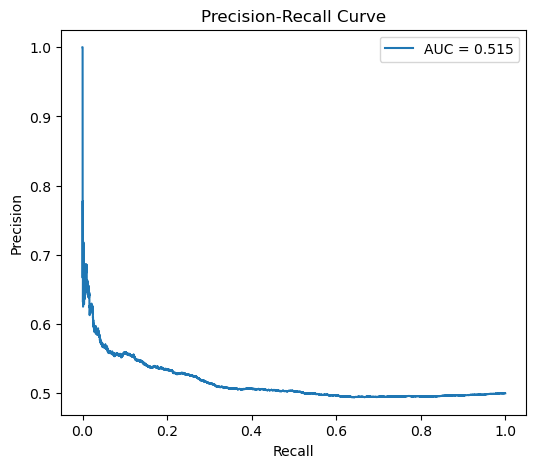

Loaded evaluation results from ./evaluation_metrics/full_fine_tuning_set_small.json
Roc curve for model:  full_fine_tuning_set_small


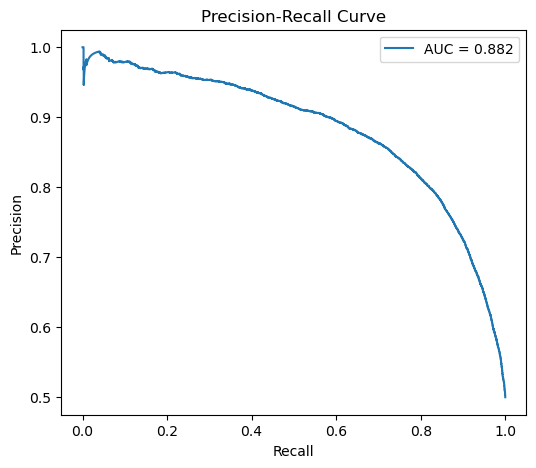

Loaded evaluation results from ./evaluation_metrics/full_fine_tuning_set_medium.json
Roc curve for model:  full_fine_tuning_set_medium


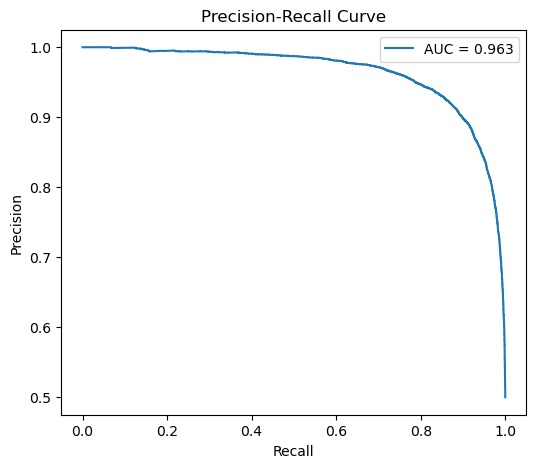

Loaded evaluation results from ./evaluation_metrics/full_fine_tuning_set_full.json
Roc curve for model:  full_fine_tuning_set_full


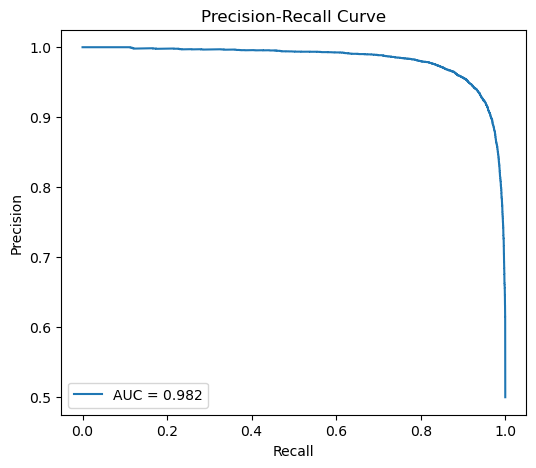

Loaded evaluation results from ./evaluation_metrics/head_fine_tuning_set_small.json
Roc curve for model:  head_fine_tuning_set_small


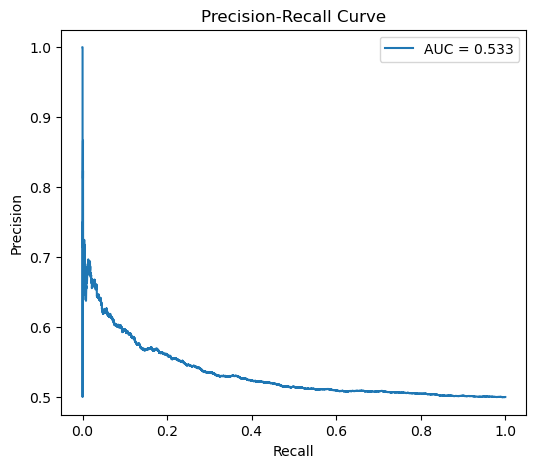

Loaded evaluation results from ./evaluation_metrics/head_fine_tuning_set_medium.json
Roc curve for model:  head_fine_tuning_set_medium


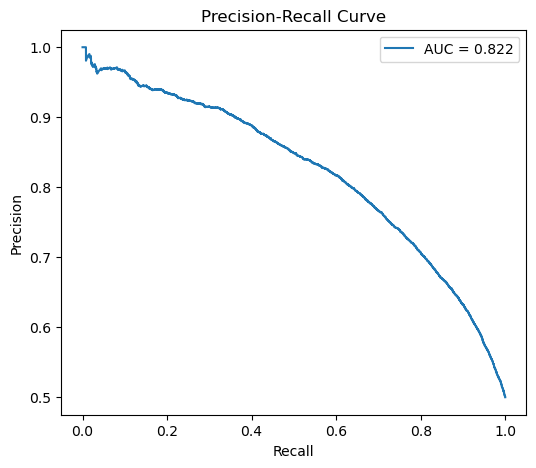

Loaded evaluation results from ./evaluation_metrics/head_fine_tuning_set_full.json
Roc curve for model:  head_fine_tuning_set_full


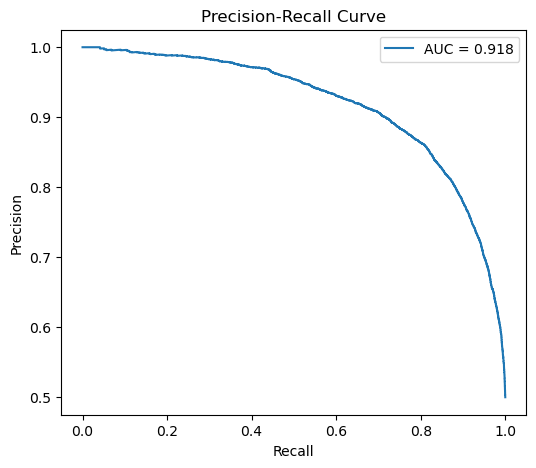

Loaded evaluation results from ./evaluation_metrics/adapters_inner_dim_48_set_small.json
Roc curve for model:  adapters_inner_dim_48_set_small


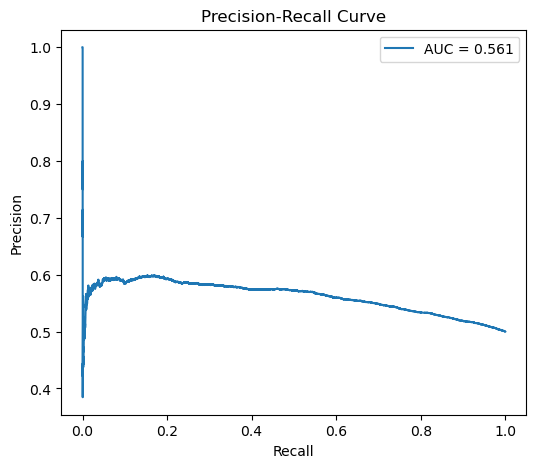

Loaded evaluation results from ./evaluation_metrics/adapters_inner_dim_48_set_medium.json
Roc curve for model:  adapters_inner_dim_48_set_medium


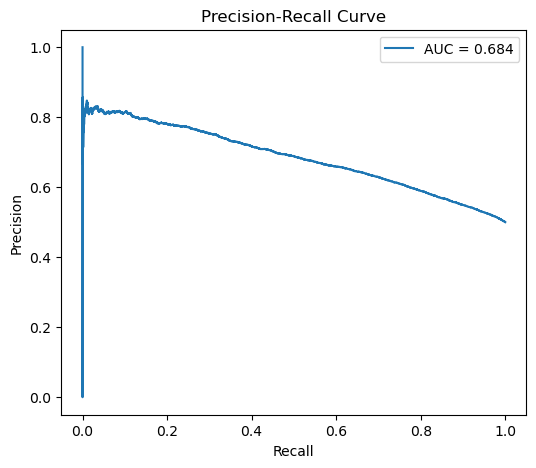

Loaded evaluation results from ./evaluation_metrics/adapters_inner_dim_48_set_full.json
Roc curve for model:  adapters_inner_dim_48_set_full


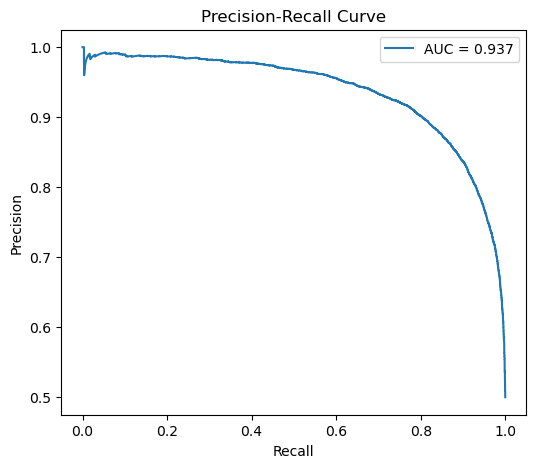

Loaded evaluation results from ./evaluation_metrics/adapters_inner_dim_96_set_small.json
Roc curve for model:  adapters_inner_dim_96_set_small


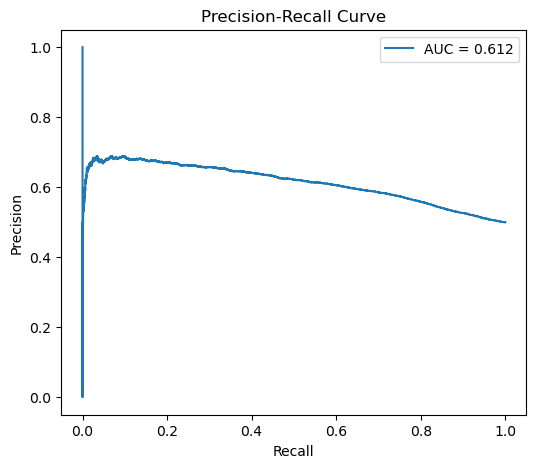

Loaded evaluation results from ./evaluation_metrics/adapters_inner_dim_96_set_medium.json
Roc curve for model:  adapters_inner_dim_96_set_medium


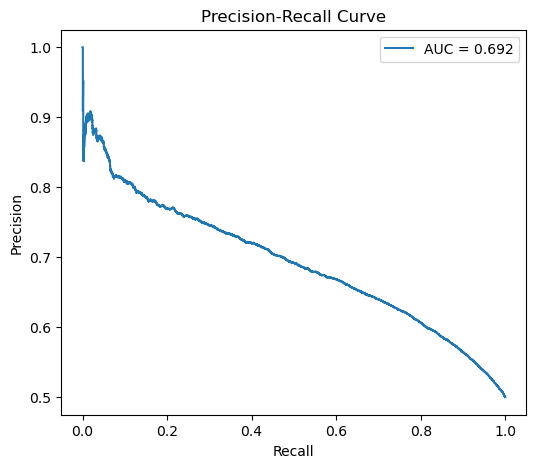

Loaded evaluation results from ./evaluation_metrics/adapters_inner_dim_96_set_full.json
Roc curve for model:  adapters_inner_dim_96_set_full


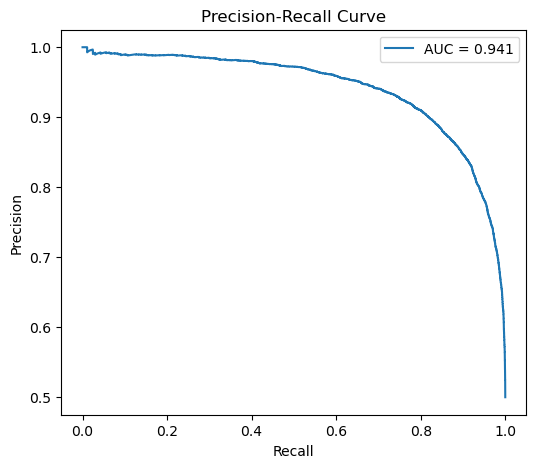

Loaded evaluation results from ./evaluation_metrics/lora_r_32_alpha_64_set_small.json
Roc curve for model:  lora_r_32_alpha_64_set_small


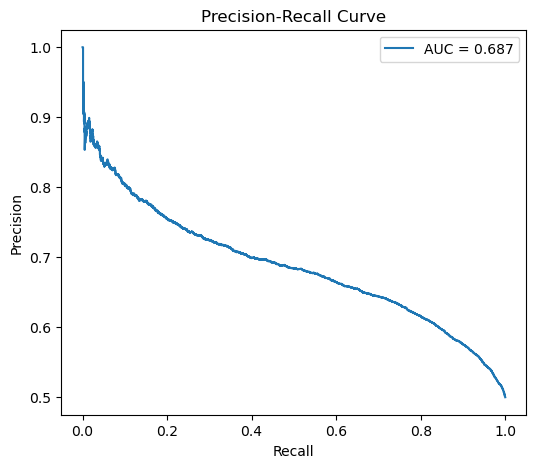

Loaded evaluation results from ./evaluation_metrics/lora_r_32_alpha_64_set_medium.json
Roc curve for model:  lora_r_32_alpha_64_set_medium


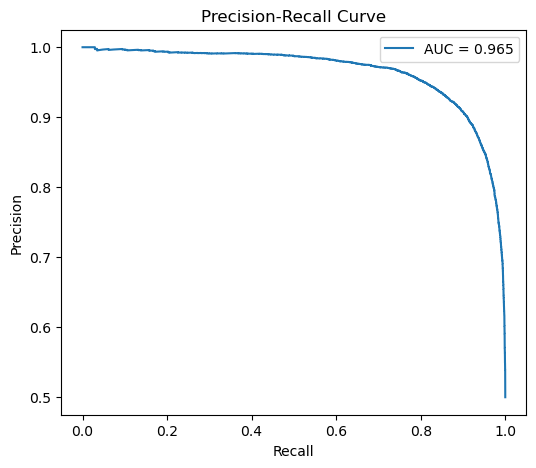

Loaded evaluation results from ./evaluation_metrics/lora_r_32_alpha_64_set_full.json
Roc curve for model:  lora_r_32_alpha_64_set_full


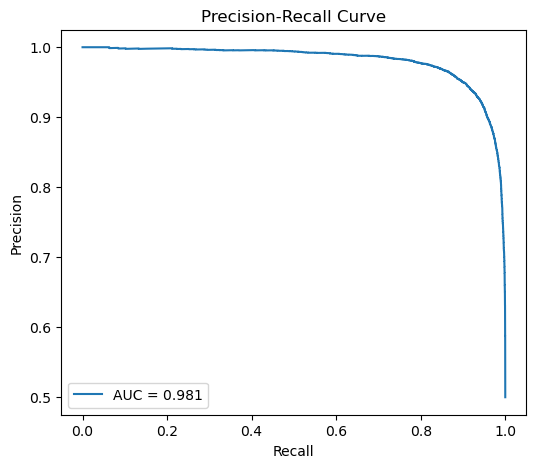

Loaded evaluation results from ./evaluation_metrics/lora_r_64_alpha_32_set_small.json
Roc curve for model:  lora_r_64_alpha_32_set_small


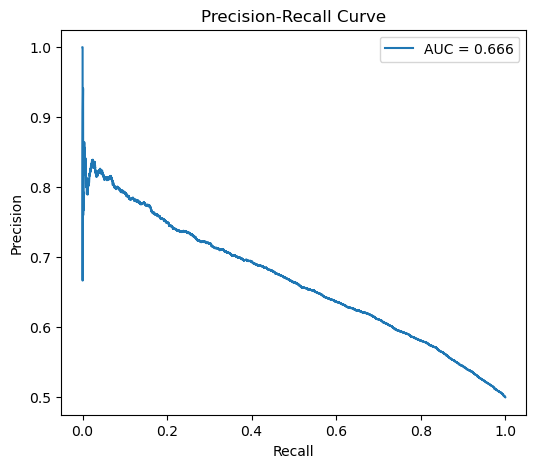

Loaded evaluation results from ./evaluation_metrics/lora_r_64_alpha_32_set_medium.json
Roc curve for model:  lora_r_64_alpha_32_set_medium


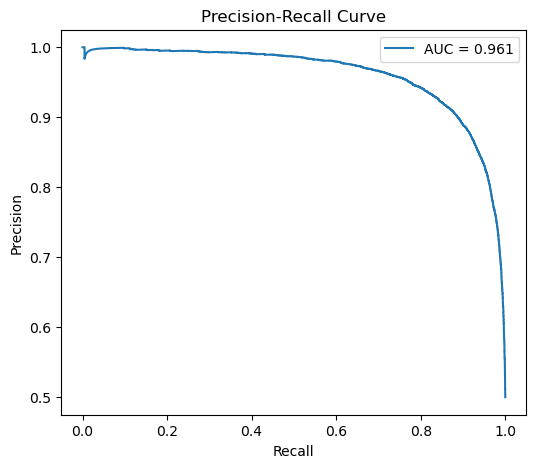

Loaded evaluation results from ./evaluation_metrics/lora_r_64_alpha_32_set_full.json
Roc curve for model:  lora_r_64_alpha_32_set_full


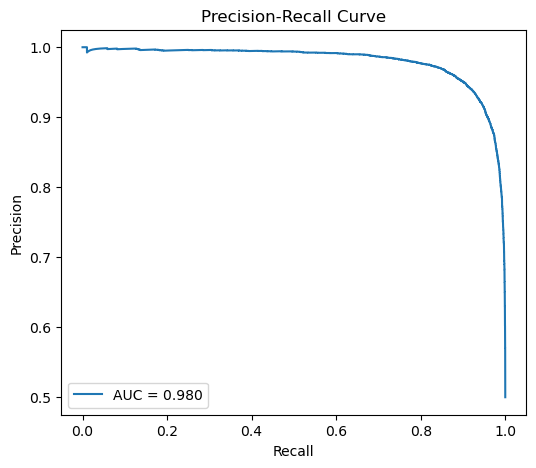

In [7]:
for model_name in MODEL_NAMES:
    loader.load_results(os.path.join(EVALUATION_PATH, model_name + '.json'))
    print('Precission recall curve for model: ', model_name)
    loader.plot_precision_recall_curve()